In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

%matplotlib inline

plt.style.use('default') # Make the graphs a bit prettier

plt.rcParams['figure.figsize'] = (12, 4)

In [2]:
#pip install -U statsmodels
import statsmodels.api as sm 

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


#  Preprocesamiento de Datos de entrenamiento

El analisis exploratorio que se presenta a continuacion tiene como fin determinar que feathers influyen en mayor medida a la hora de determinar el precio de un inmueble en Capital Federal y Gran Buenos Aires, asi como tambien encontrar datos curiosos en el data set.

Los datos fueron provistos por [Properati](http://www.properati.com.ar) y reorganizo en un solo dataset de la siguiente manera : [GitHub | properati_argentina](https://github.com/BraianVicente/properati_argentina/blob/master/src/TP1%20-%20Properati%20-%20Parseo%20de%20datos%20por%20fecha.ipynb)

In [3]:
sell_properati = pd.read_csv('../data/properati_full_month.csv',low_memory=False)

Completamos la columna 'state_name'

In [4]:
sell_properati['state_name'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[2])

Filtramos unicamente los que nos interesan que corresponde a capital federal y alrededores

In [5]:
sell_properati = sell_properati[
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Norte' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Sur' ) |
    (sell_properati['state_name'] == 'Bs.As. G.B.A. Zona Oeste' ) |
    (sell_properati['state_name'] == 'Capital Federal' ) 
    ]

In [6]:
sell_properati.shape

(416685, 31)

In [7]:
sell_properati = sell_properati[sell_properati.property_type != 'store']

In [8]:
sell_properati.shape

(408405, 31)

In [9]:
sell_properati['zone'] = sell_properati.place_with_parent_names.apply(lambda x : x.split('|')[3])

Filtramos por los datos que son reelevantes para nuestro analisis, obteniendo unicamente las propiedades de GBA y capital federal

In [10]:
sell_properati.drop(inplace=True,\
    labels=['country_name','description','extra','id', u'image_thumbnail','operation'\
            ,'place_with_parent_names_l1','place_with_parent_names_l2', 'properati_url','surface_in_m2','title',\
           ],axis=1)

Podemos seguir trabajando con los datos que no cuentan con la informacion de Zona utilizando la ubicacion para identificarlos segun el barrio al que pertenecen pero en esta ocacion decidimos dejarlos de lado pues no son una cantidad significativa de datos

#### Las propiedades del tigre son las unicas que no contienen informacion en 'place_name'

In [11]:
sell_properati.loc[pd.isnull(sell_properati['place_name']),'place_name'] = sell_properati.place_name.apply(lambda x : x if pd.notnull(x) else 'Tigre' )

In [12]:
sell_properati = sell_properati[sell_properati['zone'] != '']

In [13]:
#Calcula el precio la incognita (incognita = divisor/dividendo) para todo divisor mayor a cero y todo dividendo mayor a cero.

def dataframe_calc_value(df,incognita,divisor,dividendo):
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0)) ,incognita] = \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][divisor] / \
    df.loc[ (pd.isnull(df[incognita])) |  (df[incognita] == 0 ) & (pd.notnull(df[divisor]) ) & (df[divisor] > 0) & \
            (pd.notnull(df[dividendo]) & (df[dividendo] > 0))][dividendo]

## Continuaremos trabajando con el set de datos completo para disponer de toda la informacion.

### Se agrega la superficie total de los inmbuebles que disponen del precio por metro cuadrado en dolares


In [14]:
sell_properati_filter = sell_properati.copy()

In [15]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price_aprox_usd','price_usd_per_m2')

### Calculamos la superficie total en metros cuadrados de las propiedades que no cuentan con este dato

In [16]:
dataframe_calc_value(sell_properati_filter,'surface_total_in_m2','price','price_per_m2')

### Calculamos el precio por metro cuadrado en USD de los inmuebles que no cuentan con dicha informacion

In [17]:
dataframe_calc_value(sell_properati_filter,'price_usd_per_m2','price_aprox_usd','surface_total_in_m2')

### Se agrega el precio por metro cuadrado en la moneda actual en cada unos de las pripiedades

In [18]:
dataframe_calc_value(sell_properati_filter,'price_per_m2','price','surface_total_in_m2')

In [19]:
sell_properati_filter = sell_properati_filter[~((sell_properati_filter['surface_total_in_m2'] == 0 ) | \
                     (sell_properati_filter['price'] == 0 ))]

Filtraremos los datos que tengan una superficie total en metros cuadrados entre 0 y 1000

In [20]:
filter_properati = sell_properati_filter[(sell_properati_filter['price_aprox_usd'] < 600000) &\
                                         (sell_properati_filter['price_usd_per_m2'] < 5000) & \
                                         (sell_properati_filter['surface_total_in_m2'] < 1000)]

## Le asignamos un numero a cada state_name y cada place_name

In [21]:
df = pd.DataFrame(data=sell_properati.place_name.unique(),columns=['place_name']).reset_index()

In [22]:
df.rename(columns={'index':'id_place_name'},inplace=True)

In [23]:
filter_properati = filter_properati.merge(how='left',left_on='place_name',right_on='place_name',right=df)

In [24]:
df = pd.DataFrame(data=sell_properati.state_name.unique(),columns=['state_name']).reset_index()
df.rename(columns={'index':'id_states'},inplace=True)

In [25]:
filter_properati = filter_properati.merge(how='left',left_on='state_name',right_on='state_name',right=df)

In [26]:
df = pd.DataFrame(data=sell_properati.property_type.unique(),columns=['property_type']).reset_index()
df.rename(columns={'index':'id_property_type'},inplace=True)

In [27]:
filter_properati = filter_properati.merge(how='left',left_on='property_type',right_on='property_type',right=df)

In [28]:
data = filter_properati.drop(axis=1,labels=['created_on','currency','lat','lat-lon','lon','place_name','place_with_parent_names','price'\
                                            ,'price_aprox_local_currency','price_per_m2','price_usd_per_m2','property_type','state_name'\
                                            ,'surface_covered_in_m2','zone','geonames_id'])

In [29]:
import re

def devolverInt(x):
        return float(re.search(r'\d+', x).group())

In [30]:
data['expenses'] = data.expenses.apply(lambda x : devolverInt(x) if pd.notnull(x) else 0 )

In [31]:
data['floor'] = data.floor.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [32]:
data['price_aprox_usd'] = data.price_aprox_usd.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [33]:
data['rooms'] = data.rooms.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [34]:
data['surface_total_in_m2'] = data.surface_total_in_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

# Preprocesamiento de set de test

In [120]:
properati_testing_dataset = pd.read_csv('../data/properati_dataset_testing_noprice.csv',low_memory=False)

In [121]:
properati_testing_dataset.loc[- properati_testing_dataset.place_name.isin(sell_properati.place_name.unique()),'place_name'] = \
    properati_testing_dataset[- properati_testing_dataset.place_name.isin(sell_properati.place_name.unique())]['place_with_parent_names']\
    .apply(lambda x : (x.split('|')[3])).copy()

In [122]:
properati_testing_dataset.loc[properati_testing_dataset.property_type == 'departamento','property_type'] = 'apartment'

In [123]:
properati_testing_dataset.loc[properati_testing_dataset.property_type == 'ph','property_type'] = 'PH'

In [124]:
properati_testing_dataset.loc[properati_testing_dataset.property_type == 'casa','property_type'] = 'house'

In [125]:
df = pd.DataFrame(data=sell_properati.place_name.unique(),columns=['place_name']).reset_index()

In [126]:
df.rename(columns={'index':'id_place_name'},inplace=True)

In [127]:
properati_testing_dataset = properati_testing_dataset.merge(how='left',left_on='place_name',right_on='place_name',right=df)

In [128]:
properati_testing_dataset.loc[-properati_testing_dataset.place_name.isin(sell_properati.place_name.unique()),'id_place_name'] = -1

In [129]:
df = pd.DataFrame(data=sell_properati.state_name.unique(),columns=['state_name']).reset_index()

In [130]:
df.rename(columns={'index':'id_state_name'},inplace=True)

In [131]:
properati_testing_dataset = properati_testing_dataset.merge(how='left',left_on='state_name',right_on='state_name',right=df)

In [133]:

properati_testing_dataset.loc[-properati_testing_dataset.state_name.isin(sell_properati.state_name.unique()),'id_state_name'] = -1

In [134]:
df = pd.DataFrame(data=sell_properati.property_type.unique(),columns=['property_type']).reset_index()

In [135]:
df.rename(columns={'index':'id_property_type'},inplace=True)

In [136]:
properati_testing_dataset = properati_testing_dataset.merge(how='left',left_on='property_type',right_on='property_type',right=df)

In [137]:
properati_testing_dataset.drop(inplace=True,\
                              labels=['created_on','operation', 'country_name','description','place_with_parent_names',\
                                      'surface_covered_in_m2','lat-lon','lat','lon','property_type','place_name','state_name'],axis=1)

In [138]:
properati_testing_dataset.loc[(properati_testing_dataset.expenses == 'Sin expensas'),'expenses'] = 0

In [139]:
properati_testing_dataset.loc[(properati_testing_dataset.expenses == 'SI'),'expenses'] = '0'

In [140]:
properati_testing_dataset.loc[(properati_testing_dataset.expenses == 'NO'),'expenses'] = '0'

In [141]:
properati_testing_dataset.loc[pd.isnull(properati_testing_dataset.expenses),'expenses'] = '0 '

In [142]:
properati_testing_dataset.expenses = properati_testing_dataset.expenses.astype(str)

In [143]:
properati_testing_dataset['expenses'] = properati_testing_dataset.expenses.apply(lambda x : devolverInt(x) if pd.notnull(x) else 0 )

In [144]:
properati_testing_dataset['floor'] = properati_testing_dataset.floor.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [145]:
properati_testing_dataset['rooms'] = properati_testing_dataset.rooms.apply(lambda x : float(x) if pd.notnull(x) else 0 )

In [146]:
properati_testing_dataset['surface_total_in_m2'] = properati_testing_dataset.surface_total_in_m2.apply(lambda x : float(x) if pd.notnull(x) else 0 )

# Normalizacion de datos

In [147]:
train = data.copy()

In [148]:
train_target = train[['price_aprox_usd']].copy()

In [149]:
train.drop(inplace=True,labels=['price_aprox_usd'],axis=1)

In [150]:
testing_data_id = properati_testing_dataset[['id']].copy()

In [151]:
test = properati_testing_dataset.drop(labels=['id'],axis=1)

In [152]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 240200 entries, 0 to 240199
Data columns (total 7 columns):
expenses               240200 non-null float64
floor                  240200 non-null float64
rooms                  240200 non-null float64
surface_total_in_m2    240200 non-null float64
id_place_name          240200 non-null int64
id_states              240200 non-null int64
id_property_type       240200 non-null int64
dtypes: float64(4), int64(3)
memory usage: 14.7 MB


In [153]:
test.describe()

,surface_total_in_m2,floor,rooms,expenses,id_place_name,id_state_name,id_property_type
count,14166.000000,14166.000000,14166.000000,1.416600e+04,14166.000000,14166.000000,14166.000000
mean,130.973175,1.031272,1.484893,1.523387e+03,65.041225,1.062685,0.829663
std,1335.876895,29.206664,1.742398,8.091291e+04,73.807189,0.610089,0.531000
min,0.000000,0.000000,0.000000,0.000000e+00,-1.000000,-1.000000,0.000000
25%,36.000000,0.000000,0.000000,0.000000e+00,11.000000,1.000000,1.000000
50%,60.000000,0.000000,1.000000,0.000000e+00,34.000000,1.000000,1.000000
75%,120.000000,0.000000,3.000000,0.000000e+00,90.000000,1.000000,1.000000
max,148000.000000,2509.000000,21.000000,7.600072e+06,618.000000,3.000000,2.000000


In [154]:
for col in train.columns :
    col_mean = train[col].mean()
    col_std = train[col].std()
    train[col] = (train[col] - col_mean) / col_std

In [155]:
for col in test.columns :
    col_mean = test[col].mean()
    col_std = test[col].std()
    test[col] = (test[col] - col_mean) / col_std

In [156]:
for col in test.columns :
    print test[pd.isnull(test[col])]

Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []
Empty DataFrame
Columns: [surface_total_in_m2, floor, rooms, expenses, id_place_name, id_state_name, id_property_type]
Index: []


# Reduccion de Dimensiones

In [157]:
from sklearn import decomposition

In [158]:
svd = decomposition.TruncatedSVD(n_components=train.shape[1]-1)

In [159]:
train_transform = svd.fit_transform(train)

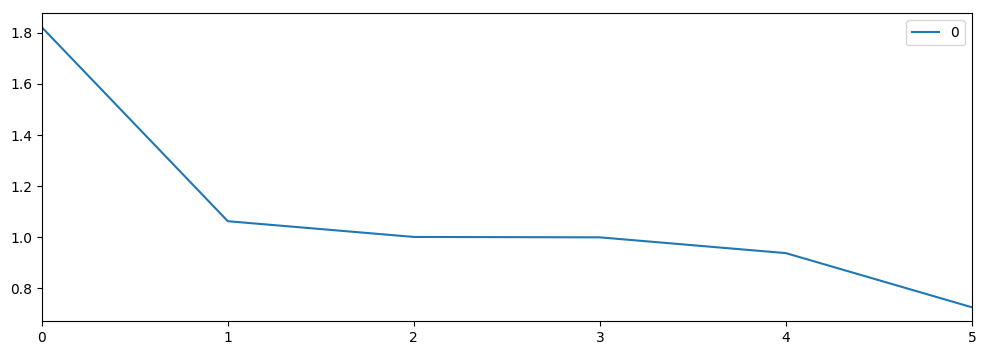

In [160]:
pd.DataFrame(svd.explained_variance_).plot()

In [161]:
test_transform = svd.transform(test)

In [162]:
test = pd.DataFrame(test_transform)

In [163]:
train = pd.DataFrame(train_transform)

# Machine Learning


In [164]:
from sklearn import neighbors

In [165]:
knn = neighbors.KNeighborsRegressor(n_neighbors=300,n_jobs=-1,p=2.5)
knn.fit(train,train_target)
test_prediction = knn.predict(test)

In [166]:
predictionDF = pd.DataFrame(test_prediction,columns={"price_usd"})

In [168]:
predictionDF['id'] = testing_data_id['id']

In [169]:
predictionDF.shape

(14166, 2)

In [170]:
predictionDF.to_csv(path_or_buf='../data/prediction_knn_300_2.5',sep=',',header=True,columns=['id','price_usd'],index=False)